# Non-zero starting and ending velocities

In some cases, you might need to retime geometic paths such the intial
and final velocities are non-zero. For instance, suppose you have
multiple paths and need to effectively *piece* them together.

This can be done in TOPP-RA by setting the `sd_start` and `sd_end` arguments.
The initial and final joint velocities are respectively:

$$
  \dot{\mathbf q}(0) = \mathbf p'(0) * \dot{s}_{start} \\
  \dot{\mathbf q}(T_{final}) = \mathbf p'(1) * \dot{s}_{end}
$$

We first randomly choose a joint velocity limit and a joint acceleration limit.

In [4]:
# toppra
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import numpy as np
# misc: for plotting and measuring time
import matplotlib.pyplot as plt
import time
ta.setup_logging()

dof = 2

# Create velocity bounds, then velocity constraint object
vlim_ = np.random.rand(dof) * 20
vlim = np.vstack((-vlim_, vlim_)).T
# Create acceleration bounds, then acceleration constraint object
alim_ = np.random.rand(dof) * 100
alim = np.vstack((-alim_, alim_)).T
pc_vel = constraint.JointVelocityConstraint(vlim)
pc_acc = constraint.JointAccelerationConstraint(
   alim, discretization_scheme=constraint.DiscretizationType.Interpolation)

Let us choose a random geometric path with three waypoints.

In [5]:
# Random waypoints used to obtain a random geometric path. Here,
# we use spline interpolation.
np.random.seed(0)
way_pts = np.random.randn(3, dof)
path = ta.SplineInterpolator(np.linspace(0, 1, 3), way_pts, bc_type='not-a-knot')

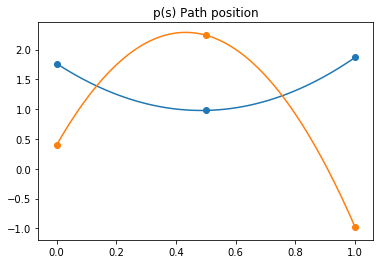

In [14]:
discretization = np.linspace(0, 1, 100)
plt.plot(discretization, path(discretization, 0), label="p(s): Path position")
plt.scatter(np.linspace(0, 1, 3), way_pts[:, 0])
plt.scatter(np.linspace(0, 1, 3), way_pts[:, 1])
plt.title("p(s) Path position")
plt.show()

Suppose we wish to solve the path parametrization instance so that the initial velocity
and final velocity are as below.

In [24]:
qd_start = path(0, 1) * 0.2
qd_final = path(path.duration, 1) * 0.2
print("Initial joint velocity: %s\nFinal joint velocity:   %s" % (qd_start, qd_final))

Initial joint velocity: [-0.64895262  1.74807581]
Final joint velocity:   [ 0.69035488 -2.29904985]


In [37]:
t0 = time.time()
# Setup a parametrization instance, then retime
instance = algo.TOPPRA([pc_vel, pc_acc], path, solver_wrapper='seidel')
jnt_traj, aux_traj, int_data = instance.compute_trajectory(0.2, 0.2, return_data=True)
print("Parameterization time: {:} secs".format(time.time() - t0))
print("Actual initial joint velocity: %s\nActual final joint velocity:   %s" % (
    jnt_traj(0, 1), jnt_traj(jnt_traj.duration, 1)
))

Parameterization time: 0.00920295715332 secs
Actual initial joint velocity: [-0.64895262  1.74807581]
Actual final joint velocity:   [ 0.69035488 -2.29904985]


We can see that the actual initial and final joint velocity equal the values we set earlier.
Below the full joint trajectory and velocity are plotted.

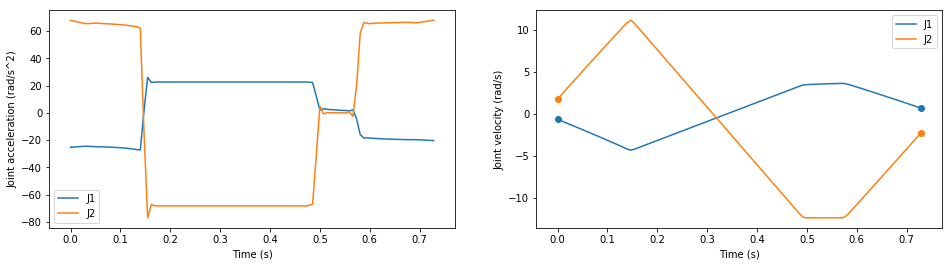

In [35]:
ts_sample = np.linspace(0, jnt_traj.get_duration(), 100)
qdds_sample = jnt_traj.evaldd(ts_sample)
qds_sample = jnt_traj.evald(ts_sample)

initial_velocities = path.evald(0) * 0.2
final_velocities = path.evald(path.duration) * 0.2
fig, axs = plt.subplots(1, 2, sharex=True, figsize=[16, 4])
for i in range(dof):
    color = "C%d" % i
    axs[0].plot(ts_sample, qdds_sample[:, i], label="J{:d}".format(i + 1), c=color)
    axs[1].plot(ts_sample, qds_sample[:, i], label="J{:d}".format(i + 1), c=color)
    axs[1].scatter([0, jnt_traj.duration],
                   [initial_velocities[i], final_velocities[i]], c=color)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Joint acceleration (rad/s^2)")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Joint velocity (rad/s)")
plt.show()
